# Nested cross-validation

Cross-validation can be used both for hyperparameter tuning and for
estimating the generalization performance of a model. However, using
it for both purposes at the same time is problematic, as the resulting
evaluation can underestimate some overfitting that results from
the hyperparameter tuning procedure itself.

Philosophically, hyperparameter tuning is a form of machine learning
itself and therefore, we need another outer loop of cross-validation to
properly evaluate the generalization performance of the full modeling
procedure.

This notebook highlights nested cross-validation and its impact on the
estimated generalization performance compared to naively using a single level
of cross-validation, both for hyperparameter tuning and evaluation of the
generalization performance.

We will illustrate this difference using the breast cancer dataset.

In [5]:
from sklearn.datasets import load_breast_cancer

data, target = load_breast_cancer(return_X_y=True)

First, we use `GridSearchCV` to find the best parameters via cross-validation
on a minimal parameter grid.

In [6]:
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC

param_grid = {'C': [0.1, 1, 10], 'gamma': [0.1, 0.1]}
model_to_tune = SVC()

search = GridSearchCV(
    estimator=model_to_tune, param_grid=param_grid, n_jobs=4
)
search.fit(data, target)

GridSearchCV(estimator=SVC(), n_jobs=4,
             param_grid={'C': [0.1, 1, 10], 'gamma': [0.1, 0.1]})

We recall that, internally, `GridSearchCV` trains several models for each on
sub-sampled training sets and evaluate each of them on the matching testing
sets using cross-validation. This evaluation procedure is controlled via
using the `cv` parameter. The procedure is then repeated for all possible
combinations of parameters given in `param_grid`.

The attribute `best_params_` gives us the best set of parameters that
maximize the mean score on the internal test sets.

In [7]:
print(f"The best parameters found are: {search.best_params_}")

The best parameters found are: {'C': 0.1, 'gamma': 0.1}


We can also show the mean score obtained by using the parameters `best_params_`.

In [8]:
print(f"The mean CV score of the best model is: {search.best_score_:.3f}")

The mean CV score of the best model is: 0.627


At this stage, one should be extremely careful using this score. The
misinterpretation would be the following: since this mean score was computed
using cross-validation test sets, we could use it to assess the
generalization performance of the model trained with the best
hyper-parameters.

However, we should not forget that we used this score to pick-up the best
model. It means that we used knowledge from the test sets (i.e. test scores)
to select the hyper-parameter of the model it-self.

Thus, this mean score is not a fair estimate of our testing error. Indeed, it
can be too optimistic, in particular when running a parameter search on a
large grid with many hyper-parameters and many possible values per
hyper-parameter. A way to avoid this pitfall is to use a "nested"
cross-validation.

In the following, we will use an inner cross-validation corresponding to the
previous procedure above to only optimize the hyperparameters. We will also
embed this tuning procedure within an outer cross-validation, which is
dedicated to estimate the testing error of our tuned model.

In this case, our inner cross-validation always gets the training set of the
outer cross-validation, making it possible to always compute the final
testing scores on completely independent sets of samples.

Let us do this in one go as follows:

In [9]:
from sklearn.model_selection import cross_val_score, KFold

# Declare the inner and outer cross-validation strategies
inner_cv = KFold(n_splits=5, shuffle=True, random_state=0)
outer_cv = KFold(n_splits=3, shuffle=True, random_state=0)

# Inner cross-validation for parameter search
model = GridSearchCV(
    estimator=model_to_tune, param_grid=param_grid, cv=inner_cv, n_jobs=4
)

# Outer cross-validation to compute the testing score
test_score = cross_val_score(model, data, target, cv=outer_cv, n_jobs=2)
print(f"The mean score using nested cross-validation is: "
      f"{test_score.mean():.3f} ± {test_score.std():.3f}")

The mean score using nested cross-validation is: 0.627 ± 0.014


The reported score is more trustworthy and should be close to production's
expected generalization performance. Note that in this case, the two score
values are very close for this first trial.

We would like to better assess the difference between the nested and
non-nested cross-validation scores to show that the latter can be too
optimistic in practice. To do this, we repeat the experiment several times
and shuffle the data differently to ensure that our conclusion does not
depend on a particular resampling of the data.

In [10]:
test_score_not_nested = []
test_score_nested = []

N_TRIALS = 20
for i in range(N_TRIALS):
    # For each trial we use cross-validation splits on independently
    # randomly shuffles data by passing distinct values to the random_state
    # parameter.
    inner_cv = KFold(n_splits=5, shuffle=True, random_state=i)
    outer_cv = KFold(n_splits=3, shuffle=True, random_state=i)

    # Non-nestes parameter seach and scoreing
    model = GridSearchCV(estimator=model_to_tune, param_grid=param_grid,
                         cv=inner_cv, n_jobs=2)
    model.fit(data, target)
    test_score_not_nested.append(model.best_score_)

    # Nested CV with parameter optimization
    test_score = cross_val_score(model, data, target, cv=outer_cv, n_jobs=2)
    test_score_nested.append(test_score.mean())

We can merge the data together and make a box plot of the two strategies.

In [11]:
import pandas as pd

all_scores = {
    'Not nested CV': test_score_not_nested,
    'Nested CV': test_score_nested
}
all_scores = pd.DataFrame(all_scores)

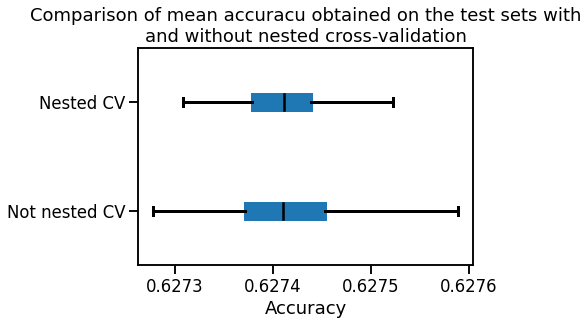

In [12]:
import matplotlib.pyplot as plt

color = {'whiskers': 'black', 'medians': 'black', 'caps': 'black'}
all_scores.plot.box(color=color, vert=False)
plt.xlabel('Accuracy')
_ = plt.title('Comparison of mean accuracu obtained on the test sets with\n'
              'and without nested cross-validation')

We observe that the generalization performance estimated without using nested
CV is higher than what we obtain with nested CV. The reason is that the
tuning procedure itself selects the model with the highest inner CV score. If
there are many hyper-parameter combinations and if the inner CV scores have
comparatively large standard deviations, taking the maximum value can lure
the naive data scientist into over-estimating the true generalization
performance of the result of the full learning procedure. By using an outer
cross-validation procedure one gets a more trustworthy estimate of the
generalization performance of the full learning procedure, including the
effect of tuning the hyperparameters.

As a conclusion, when optimizing parts of the machine learning pipeline (e.g.
hyperparameter, transform, etc.), one needs to use nested cross-validation to
evaluate the generalization performance of the predictive model. Otherwise,
the results obtained without nested cross-validation are often overly
optimistic.